## 深度学习演示2：实现一个最简单的Deep Dream

Deep Dream是一个非常有趣的算法，利用已经训练好的卷积网络模型，对输入图像进行反向修改，放大卷积网络中某部分的输出。

这里演示一个最简单的反向图像生成。和之前的演示一样，我们同样使用VGG的ImageNet模型。

* Google的论文和伪代码

https://github.com/google/deepdream 

* 基于Python和Caffe的实现

https://github.com/jrosebr1/bat-country

https://github.com/jcjohnson/cnn-vis

＊ 基于Torch的实现

https://github.com/eladhoffer/DeepDream.torch 

https://github.com/Teaonly/easyStyle (鄙人的简单实现）


### 1. 裁减模型，去掉顶部的全连接层


In [15]:
require('nn')
require('image')
require('loadcaffe')
require('cunn')

torch.setdefaulttensortype('torch.FloatTensor')

--装载原始模型
fullModel = loadcaffe.load('vgg19/VGG_ILSVRC_19_layers_deploy.prototxt', 'vgg19/VGG_ILSVRC_19_layers.caffemodel', 'nn')
fullModel:evaluate()

cnnModel = nn.Sequential()
for i = 1, 27 do
    cnnModel:add( fullModel.modules[i] )
end
cnnModel:float()
cnnModel:evaluate()



collectgarbage()

Successfully loaded vgg19/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3


conv3_2: 256 256 3 3
conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


### 2. 准备图像以及预处理

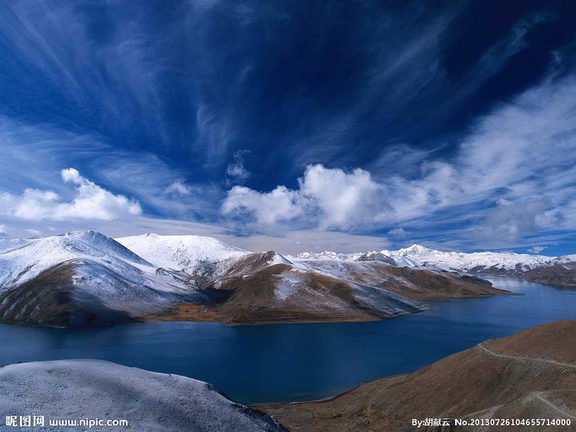

In [2]:
require('image')

orignalImg = image.loadPNG('./input.png', 3)
itorch.image(orignalImg)

orignalImg = orignalImg:float() * 256
for j = 1, 3 do
  orignalImg[{j, {}, {}}] = orignalImg[{j, {}, {}}] - 128
end


### 3. 实施Deep Dream

==>总用时：3.2743501663208	


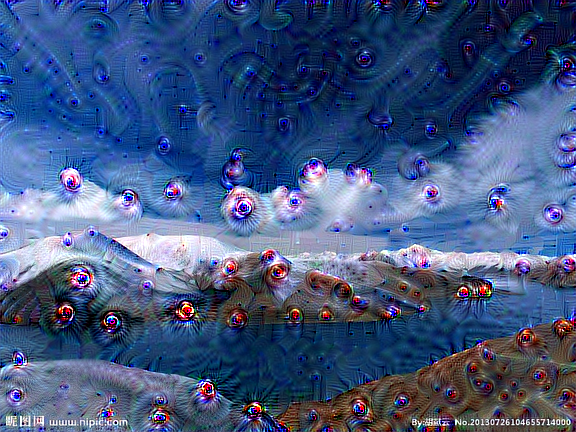

In [14]:
require("cunn")

local maxIterator = 20
local enhenceImageGPU = function (inputImage) 
    local targetImg = inputImage:clone()
    targetImg = targetImg:cuda()
    
    for i = 1, maxIterator do
        local inputOuput = cnnModel:forward(targetImg)

        -- 从神经网络的输出层，制造loss函数，输出 dloss
        local amplifyDiff = inputOuput:clone()
        amplifyDiff:mul(-1) -- 乘以－1，表示放大这个神经层

        inputOuput = cnnModel:backward(targetImg, amplifyDiff)
        local scale = 1.5 / torch.mean(torch.abs(inputOuput))
        targetImg:add(inputOuput*(-1*scale))
        
        collectgarbage()
    end
    targetImg = targetImg:float()
    clipImage(targetImg)
    for j = 1, 3 do
      targetImg[{j, {}, {}}] = targetImg[{j, {}, {}}] + 128
    end
    targetImg = targetImg / 256
    return targetImg 
end

cnnModel:cuda()

local te = sys.clock()
local outImage = enhenceImageGPU(orignalImg)
print("==>总用时：" .. (sys.clock() - te) )

itorch.image(outImage)
